# Import packages

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from ray import tune
from ray.tune.integration.keras import TuneReportCallback
from tensorflow.data import Dataset
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)
plt.style.use('_mpl-gallery')

## Set Hyperparameter

In [2]:
try:
    os.mkdir("./output")
except:
    pass
PROJECT_NAME = "digit-recognizer"
DATA_PATH = os.path.join(os.getcwd()[:-8], "input", PROJECT_NAME)
BATCH_SIZE = 128
EPOCH = 5
PATIENCE = 10

## Dataset

In [3]:
def get_train_dataset(only_valid_data=False):
    train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))

    x_train = train_data.iloc[:,1:].to_numpy().reshape(-1, 28, 28, 1)
    y_train = train_data.label.to_numpy()
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, 
        test_size=0.2, random_state=1234)
    # Feature engineering
    x_train, x_valid = x_train/255, x_valid/255
    if only_valid_data:
        return x_valid, y_valid
    else:
        # Dataset
        train_ds = Dataset.from_tensor_slices((x_train, y_train))
        valid_ds = Dataset.from_tensor_slices((x_valid, y_valid))
        # Data Augmentation
        train_ds = train_ds.map(augment_iamge, 
            num_parallel_calls=tf.data.AUTOTUNE)
        train_ds = train_ds.batch(BATCH_SIZE)
        valid_ds = valid_ds.batch(BATCH_SIZE)
        return train_ds, valid_ds

In [4]:
def get_test_dataset():
    test_data  = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

    x_test = test_data.to_numpy().reshape(-1, 28, 28, 1)
    # Feature engineering
    x_test = x_test/255
    # Dataset
    test_ds = Dataset.from_tensor_slices((x_test))
    test_ds = test_ds.batch(BATCH_SIZE)
    return test_ds

## Data Augmentation

In [5]:
transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.15, 
        scale_limit=0.2, 
        rotate_limit=25, 
        border_mode=cv2.BORDER_CONSTANT, p=0.75),
    ])

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    return aug_img

def augment_iamge(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

In [6]:
def plot_images(train_ds):
    image_batch, label_batch = next(iter(train_ds))

    plt.figure(figsize=(9, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image_batch[i].numpy(), cmap='gray')
        label = label_batch[i].numpy()
        plt.title(label)
        plt.axis("off")
    plt.show()

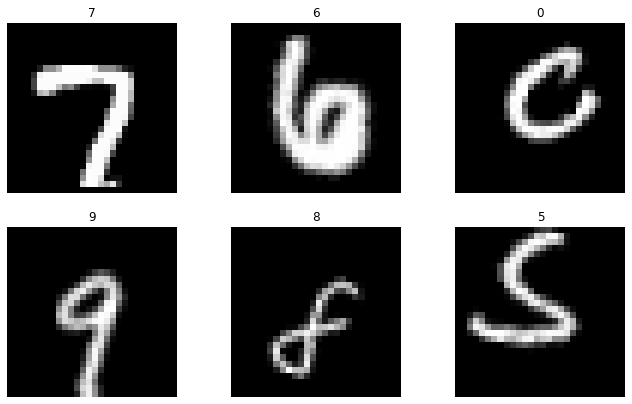

In [7]:
train_ds, valid_ds = get_train_dataset()
plot_images(train_ds)

## Model

In [8]:
def get_model(config):
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(config["filters_1"], 3, activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(config["filters_1"], 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(config["filters_2"], 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(config["filters_2"], 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

## Train Model

In [10]:
def train_model(config):
    train_ds, valid_ds = get_train_dataset()
    model = get_model(config)
    model.compile(optimizer=optimizers.Adam(learning_rate=config["lr"]),
                  loss=losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    tunereport_callback = TuneReportCallback(
        {"accuracy": "accuracy",
         "loss": "loss",
         "val_accuracy": "val_accuracy",
         "val_loss": "val_loss"})

    checkpoint_callback = ModelCheckpoint(
        filepath="./model.h5", 
        monitor='val_accuracy', 
        save_best_only=True)
    
    earlystop_callback = EarlyStopping(
        patience=PATIENCE, 
        monitor='val_accuracy')

    callbacks = [
        checkpoint_callback,
        earlystop_callback,
        tunereport_callback]

    model.fit(train_ds, validation_data=valid_ds, 
        epochs=EPOCH, verbose=0, callbacks=callbacks)

## Hyperparameter Tuning

In [11]:
search_space = {
    "filters_1": tune.grid_search([16, 32, 64]),
    "filters_2": tune.grid_search([16, 32, 64]),
    "lr": tune.grid_search([0.005, 0.01, 0.05])
    }

analysis = tune.run(
    train_model,
    config=search_space,
    resources_per_trial={'gpu': 1},
    local_dir='./output/',
    verbose=1,
    fail_fast=True
    )

(pid=) 2022-06-30 23:11:56,267	INFO context.py:67 -- Exec'ing worker with command: "c:\Users\wayne\anaconda3\envs\DL\python.exe" c:\Users\wayne\anaconda3\envs\DL\lib\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=4430 --object-store-name=tcp://127.0.0.1:57448 --raylet-name=tcp://127.0.0.1:42214 --redis-address=None --storage=None --temp-dir=C:\Users\wayne\AppData\Local\Temp\ray --metrics-agent-port=60473 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:22222 --redis-password=5241590000000000 --startup-token=9 --runtime-env-hash=469889963


In [ ]:
print("Best hyperparameters found were:")
best_trial = analysis.get_best_trial("val_accuracy", "max", "last")

for k, v in analysis.get_all_configs().items():
    if v == best_trial.config:
        keys = k
        break
print(best_trial.config)

Best hyperparameters found were:
{'filters_1': 16, 'filters_2': 64, 'lr': 0.005}


In [ ]:
config_list = []
for i in analysis.get_all_configs().keys():
    config_list.append(analysis.get_all_configs()[i])

accury_list = []
dfs = analysis.trial_dataframes
for i, d in enumerate(dfs.values()):
    accury_list.append(d.val_accuracy.max())
# Top 3
index = sorted(range(len(accury_list)), key=lambda i: accury_list[i])[-3:]

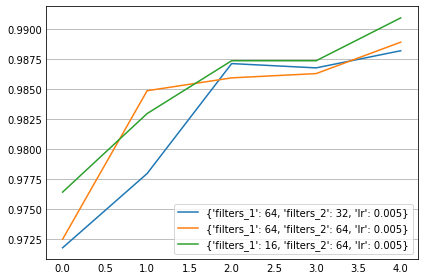

In [ ]:
plt.figure(figsize=(6, 4))
for i in index:
    dfs[list(dfs.keys())[i]].val_accuracy.plot(label=str(config_list[i]))
plt.legend()
plt.tight_layout()
plt.grid(axis='x')
plt.show()

## Vaildate the best model

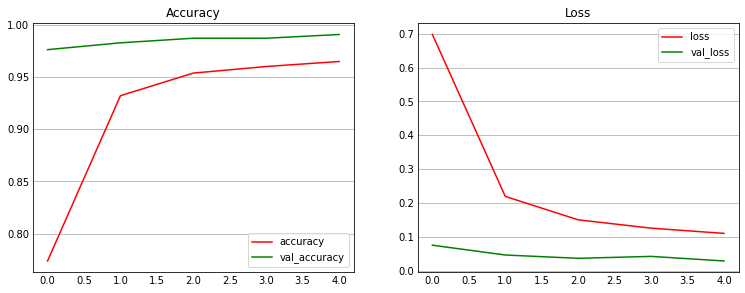

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Accuracy')
ax1.plot(dfs[keys]['accuracy'], 'r', label='accuracy')
ax1.plot(dfs[keys]['val_accuracy'], 'g', label='val_accuracy')
ax1.legend()
ax1.grid(axis='x')

ax2.set_title('Loss')
ax2.plot(dfs[keys]['loss'], 'r', label='loss')
ax2.plot(dfs[keys]['val_loss'], 'g', label='val_loss')
ax2.legend()
ax2.grid(axis='x')

plt.show()

In [ ]:
logdir = analysis.get_best_logdir("val_accuracy", mode="max")
model = tf.keras.models.load_model(os.path.join(logdir, 'model.h5'))

In [ ]:
x_valid, y_valid = get_train_dataset(only_valid_data=True)

valid_ds = Dataset.from_tensor_slices((x_valid))
valid_ds = valid_ds.batch(BATCH_SIZE)

y_valid_pred = np.argmax(model.predict(valid_ds, verbose=0), axis=1)

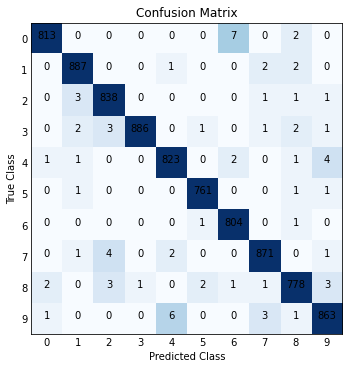

In [ ]:
matrix = confusion_matrix(y_valid, y_valid_pred)

plt.figure(figsize=(5, 5))
plt.imshow(matrix, vmin=0, vmax=20)
for i in range(10):
    for j in range(10):
        plt.text(x=i, y=j, s=matrix[j, i], horizontalalignment='center')
plt.title("Confusion Matrix")
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.grid(0)
plt.show()

## Submit the prediction of test dataset

In [ ]:
test_ds = get_test_dataset()
y_test_pred = np.argmax(model.predict(test_ds), axis=1)

output = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
output['Label'] = y_test_pred
output.to_csv('./digit-recognizer.csv', index=False)

110/110 [==============================] - 1s 10ms/step
